In [1]:

# import zipfile

# # Specify the zip file path
# zip_file_path = 'Gun_NoGun_Dataset_augmented.zip'

# # Specify the extraction path
# extract_path = '.'

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all files
#     zip_ref.extractall(extract_path)

# print(f'Zip file extracted to {extract_path}')

In [2]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from moviepy.editor import *
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Input, RepeatVector, Dropout
from keras.models import Model
from keras.optimizers import Nadam, Adam
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout

2025-01-08 20:22:31.769754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 20:22:31.783021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 20:22:31.787059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 20:22:31.796474: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-08 20:22:32.362965: W tensorflow/compiler/tf2

In [3]:
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model

In [4]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [5]:
data_dir =  "Gun_NoGun_Dataset_augmented/"
IMAGE_HEIGHT, IMAGE_WIDTH= 224,224

SEQUENCE_LENGTH =30

In [6]:
class_categories_list = ["Gun", "NoGun"]
model_output_length = len(class_categories_list)

In [7]:
max_pixel_value = 255
def extract_frame(video_path):
  # frames_list = []

  # #print(" the video file path is : {}".format(video_path))
  # videoObj = cv2.VideoCapture(video_path)
  # #print("the video object is: {}".format(videoObj))

  # """ Iterating through Video Frames """
  # while True:

  #   # Reading a frame from the video file
  #   success, image = videoObj.read()
  #   #print("the value of success is: {}".format(success))

  #   if not success:
  #     break

  #   resized_frame = cv2.resize(image, (image_height, image_width))

  #   """Normalize the resized frame by dividing it with 255 so that 
  #   each pixel value then lies between 0 and 1"""

  #   normalized_frame = resized_frame / max_pixel_value
  #   frames_list.append(normalized_frame)

    
  # videoObj.release()


    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
    
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
    
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
    
        if not success:
            break
    
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    
    video_reader.release()


    return frames_list



In [8]:
def data_creation():

    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(class_categories_list):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(data_dir, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(data_dir, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = extract_frame(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [9]:
features, labels = data_creation()

Extracting Data of Class: Gun
Extracting Data of Class: NoGun


In [10]:
print("the shape of the feature = {}".format(features.shape))
print("the shape of the labels = {}".format(labels.shape))

the shape of the feature = (516, 30, 224, 224, 3)
the shape of the labels = (516,)


In [11]:
one_hot_encoded_labels = to_categorical(labels)

In [12]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, 
                                                                            test_size = 0.2, 
                                                                            shuffle = True, 
                                                                            random_state = 0)

In [13]:
print("the shape of the feature = {}".format(features_train.shape))
print("the shape of the labels = {}".format(labels_train.shape))

the shape of the feature = (412, 30, 224, 224, 3)
the shape of the labels = (412, 2)


In [14]:
print("the shape of the feature = {}".format(features_test.shape))
print("the shape of the labels = {}".format(labels_test.shape))

the shape of the feature = (104, 30, 224, 224, 3)
the shape of the labels = (104, 2)


In [15]:
from tensorflow.keras.models import load_model

no_of_channels = 3

# Load the saved model
VGG_model = load_model('VGG16_Date_Time_2024_08_17__16_23_00___Loss_0.13619327545166016___Accuracy_0.9503968358039856.h5')


# Define the input shape
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, no_of_channels)

# Remove the classification head (last layer)
VGG_model = Model(inputs=VGG_model.inputs, outputs=VGG_model.layers[-5].output)

# Set the new input shape
VGG_model.build(input_shape)

# Print the updated model summary
VGG_model.summary()

I0000 00:00:1736385921.216790 3728975 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736385921.220477 3728975 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736385921.248169 3728975 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736385921.251331 3728975 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
video_input = Input(shape=(SEQUENCE_LENGTH,
                           IMAGE_HEIGHT,
                            IMAGE_WIDTH,
                            no_of_channels))

In [17]:
video_frames_encoded = TimeDistributed(VGG_model)(video_input)

In [18]:
video_frames_encoded

<KerasTensor shape=(None, 30, 512), dtype=float32, sparse=False, name=keras_tensor_49>

In [19]:
no_of_classes = 2

In [20]:
video_frames_encoded_sequence = LSTM(256)(video_frames_encoded)
#video_frames_encoded_sequence = Dropout(0.5)(video_frames_encoded_sequence)

hidden_layer1 = Dense(1024, activation="relu")(video_frames_encoded_sequence)
#hidden_layer1 = Dropout(0.5)(hidden_layer1)

hidden_layer2 = Dense(512, activation="relu")(hidden_layer1)
#hidden_layer2 = Dropout(0.5)(hidden_layer2)

hidden_layer3 = Dense(256, activation="relu")(hidden_layer2)
#hidden_layer3 = Dropout(0.25)(hidden_layer3)

hidden_layer4 =  Dense(128, activation="relu")(hidden_layer3)
#hidden_layer4 = Dropout(0.25)(hidden_layer4)

hidden_layer5 =  Dense(64, activation="relu")(hidden_layer4)
#hidden_layer5 = Dropout(0.25)(hidden_layer5)

outputs = Dense(no_of_classes, activation="softmax")(hidden_layer5)
model = Model([video_input], outputs)

In [21]:
optimizer = Adam(learning_rate=0.00001)
                  # beta_1=0.9,
                  # beta_2=0.999,
                  # epsilon=1e-08,
                  # weight_decay=0.004)

In [22]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]) 

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 512)        │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,462,722 (62.80 MB)

 Trainable params: 1,748,034 (6.67 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor="val_loss",
                      mode="min",
                      restore_best_weights=True,
                      patience=10)
checkpoint = ModelCheckpoint('VGG+LSTM_best_weights.keras',
                             monitor='val_accuracy',
                            #  monitor='val_f1_score',
                             verbose=1,
                             mode='max',
                             save_best_only=True)
callbacks = [early_stopping_callback, checkpoint]

In [25]:
features_train.shape, labels_train.shape

((412, 30, 224, 224, 3), (412, 2))

In [26]:
# Start Training
model_training_history = model.fit(x = features_train, 
                                   y = labels_train, 
                                   epochs = 150, 
                                   batch_size = 16,
                                   shuffle = True, 
                                   callbacks=[callbacks],
                                   validation_split = 0.2)

2025-01-08 20:25:59.041566: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5942845440 exceeds 10% of free system memory.
2025-01-08 20:26:00.981196: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5942845440 exceeds 10% of free system memory.


Epoch 1/150


2025-01-08 20:26:11.519851: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1736385971.802565 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385971.822764 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385971.824090 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385971.829401 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385971.837440 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385971.850337 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385971.851078 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385971.916230 3744024 gpu_t

20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.5969 - loss: 0.6853

W0000 00:00:1736385983.455325 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385983.455902 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385983.456425 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385983.456934 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385983.457431 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385983.457959 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385983.458484 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385983.459060 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385983.459674 3744024 gp

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.5954 - loss: 0.6853

W0000 00:00:1736385984.183500 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385984.187587 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385984.188507 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385984.189414 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385984.190329 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385984.191232 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385984.192143 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385984.193111 3744024 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736385984.194072 3744024 gp


Epoch 1: val_accuracy improved from -inf to 0.49398, saving model to VGG+LSTM_best_weights.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 803ms/step - accuracy: 0.5940 - loss: 0.6854 - val_accuracy: 0.4940 - val_loss: 0.6956
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.5845 - loss: 0.6767
Epoch 2: val_accuracy did not improve from 0.49398
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 631ms/step - accuracy: 0.5835 - loss: 0.6769 - val_accuracy: 0.4940 - val_loss: 0.6946
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.5845 - loss: 0.6743
Epoch 3: val_accuracy did not improve from 0.49398
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 638ms/step - accuracy: 0.5835 - loss: 0.6745 - val_accuracy: 0.4940 - val_loss: 0.6936
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.5845 - loss: 0.6725
Epoch 4: val_accuracy did not improve from 0.49398
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 641ms/step - accuracy: 0.5835 - loss: 0.6726 - val_accuracy: 0.4940 - val_loss: 0.6920
Epoch 5/150
21/2

In [27]:
features_test.shape

(104, 30, 224, 224, 3)

In [28]:
# import datetime as dt

# model2_evaluation_history = model.evaluate(features_test, labels_test)

# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()

# current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
# model_evaluation_loss, model_evaluation_accuracy = model2_evaluation_history
# model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
# # Saving your Model
# model.save(model_name)


In [29]:
m=load_model("VGG+LSTM_best_weights.keras")
labels_pred_prob = m.predict(features_test)

W0000 00:00:1736387562.967253 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387562.968295 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387562.969271 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387562.970243 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387562.971215 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387562.972326 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387562.973454 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387562.974835 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387562.976151 3744026 gp

1/4 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step

W0000 00:00:1736387565.833886 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387565.834883 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387565.835789 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387565.836781 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387565.837685 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387565.838665 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387565.839669 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387565.840712 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387565.841751 3744026 gp

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step

W0000 00:00:1736387569.368794 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387569.369337 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387569.369807 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387569.370283 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387569.370750 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387569.371250 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387569.371739 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387569.372273 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387569.372845 3744026 gp

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  


W0000 00:00:1736387570.048288 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387570.049432 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387570.050598 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387570.051843 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387570.053081 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387570.054463 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387570.055812 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387570.057165 3744026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736387570.058564 3744026 gp

In [30]:
labels_pred_prob

array([[9.99019265e-01, 9.80772893e-04],
       [1.70109987e-01, 8.29890013e-01],
       [9.87682283e-01, 1.23176798e-02],
       [1.25061674e-03, 9.98749375e-01],
       [3.32383672e-04, 9.99667645e-01],
       [1.34933954e-02, 9.86506581e-01],
       [9.93684709e-01, 6.31524436e-03],
       [9.87520576e-01, 1.24793937e-02],
       [5.10500868e-05, 9.99948978e-01],
       [9.76746321e-01, 2.32536737e-02],
       [9.98191416e-01, 1.80860737e-03],
       [2.57615582e-04, 9.99742329e-01],
       [1.16965721e-05, 9.99988317e-01],
       [1.47825785e-05, 9.99985218e-01],
       [9.98891771e-01, 1.10825384e-03],
       [9.96554375e-01, 3.44567839e-03],
       [1.70057967e-01, 8.29942048e-01],
       [1.07204105e-04, 9.99892831e-01],
       [1.21410194e-05, 9.99987841e-01],
       [9.96843457e-01, 3.15652718e-03],
       [9.67106104e-01, 3.28938514e-02],
       [9.65116441e-01, 3.48834768e-02],
       [4.07701870e-03, 9.95922923e-01],
       [2.35355168e-04, 9.99764621e-01],
       [9.216104

In [32]:
labels_pred = np.argmax(labels_pred_prob, axis = 1)
labels_test = np.argmax(labels_test, axis = 1)
labels_pred, labels_test

(array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]),
 array([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]))

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, labels_pred)
print(cm)

[[54  0]
 [ 2 48]]


In [34]:
from sklearn.metrics import classification_report
report = classification_report(labels_test, labels_pred)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        54
           1       1.00      0.96      0.98        50

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104



In [47]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels_test, labels_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(labels_test, labels_pred_prob[:, 1])
print(auc_score)

0.995925925925926


In [48]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.03703704, 0.03703704,
        0.16666667, 0.16666667, 1.        ]),
 array([0.  , 0.02, 0.96, 0.96, 0.98, 0.98, 1.  , 1.  ]),
 array([       inf, 0.9999815 , 0.43351522, 0.32702237, 0.21198942,
        0.04140114, 0.02653676, 0.00130547], dtype=float32))

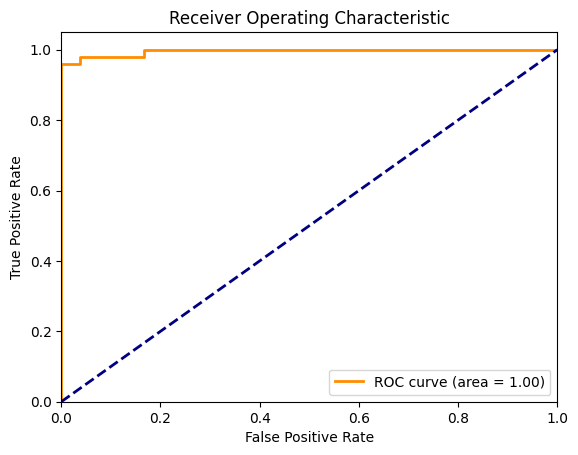

In [49]:
# Plot ROC curve
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
labels_pred_prob = model.predict(features_test)

W0000 00:00:1725938900.407364 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938900.412718 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938900.422800 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938900.437092 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938900.451637 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938900.464012 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938900.466943 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938900.473074 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938900.487836 3169143 gp

1/4 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step

W0000 00:00:1725938907.418994 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938907.421489 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938907.423598 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938907.425347 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938907.427162 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938907.429026 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938907.434584 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938907.442276 3169143 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938907.449919 3169143 gp

3/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

W0000 00:00:1725938912.649752 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938912.650815 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938912.652859 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938912.654087 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938912.655192 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938912.656329 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938912.657417 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938912.658575 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938912.659765 3169141 gp

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


W0000 00:00:1725938914.337289 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938914.338673 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938914.340100 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938914.341349 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938914.342458 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938914.343573 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938914.344677 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938914.345924 3169141 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938914.347332 3169141 gp

In [30]:
labels_pred_prob

array([[9.99822199e-01, 1.77846334e-04],
       [2.80269631e-03, 9.97197270e-01],
       [9.86850798e-01, 1.31492047e-02],
       [1.16046635e-04, 9.99883890e-01],
       [4.63354409e-05, 9.99953628e-01],
       [2.22533219e-03, 9.97774661e-01],
       [9.98746276e-01, 1.25369860e-03],
       [8.85939360e-01, 1.14060648e-01],
       [8.63811874e-06, 9.99991417e-01],
       [8.68108571e-01, 1.31891429e-01],
       [9.99564707e-01, 4.35266091e-04],
       [3.70253838e-05, 9.99962926e-01],
       [1.87882301e-06, 9.99998093e-01],
       [2.04985372e-06, 9.99997973e-01],
       [9.99792039e-01, 2.07927893e-04],
       [9.99214053e-01, 7.85961456e-04],
       [1.68582425e-03, 9.98314142e-01],
       [1.72693944e-05, 9.99982715e-01],
       [1.92414132e-06, 9.99998093e-01],
       [9.99254763e-01, 7.45164987e-04],
       [4.13250923e-01, 5.86749077e-01],
       [7.40548611e-01, 2.59451389e-01],
       [7.41446624e-04, 9.99258578e-01],
       [5.12000515e-05, 9.99948740e-01],
       [3.638334

In [31]:
labels_pred = np.argmax(labels_pred_prob, axis = 1)
labels_test = np.argmax(labels_test, axis = 1)
labels_pred, labels_test

(array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]),
 array([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]))

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, labels_pred)
print(cm)

[[48  6]
 [ 1 49]]


In [33]:
from sklearn.metrics import classification_report
report = classification_report(labels_test, labels_pred)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.98      0.89      0.93        54
           1       0.89      0.98      0.93        50

    accuracy                           0.93       104
   macro avg       0.94      0.93      0.93       104
weighted avg       0.94      0.93      0.93       104



In [34]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels_test, labels_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(labels_test, labels_pred_prob[:, 1])
print(auc_score)

0.997037037037037


In [35]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.14814815, 0.14814815,
        1.        ]),
 array([0.  , 0.02, 0.04, 0.1 , 0.14, 0.16, 0.2 , 0.98, 0.98, 1.  , 1.  ]),
 array([          inf, 9.9999905e-01, 9.9999893e-01, 9.9999881e-01,
        9.9999869e-01, 9.9999821e-01, 9.9999809e-01, 9.3856734e-01,
        2.5945139e-01, 1.3189143e-01, 1.7784633e-04], dtype=float32))

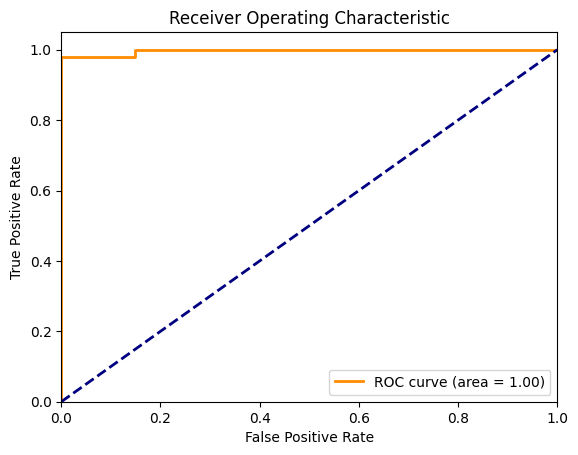

In [36]:
# Plot ROC curve
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metric(measure_name_1, measure_name_2, plot_title):
  
 
  measure_value_1 = model_training_history.history[measure_name_1]
  measure_value_2 = model_training_history.history[measure_name_2] 
  epochs = range(len(measure_value_1))

  plt.plot(epochs, measure_value_1, 'blue', label = measure_name_1)
  plt.plot(epochs, measure_value_2, 'red', label = measure_name_2)   

  plt.title(str(plot_title))
  plt.legend()
  plt.show()


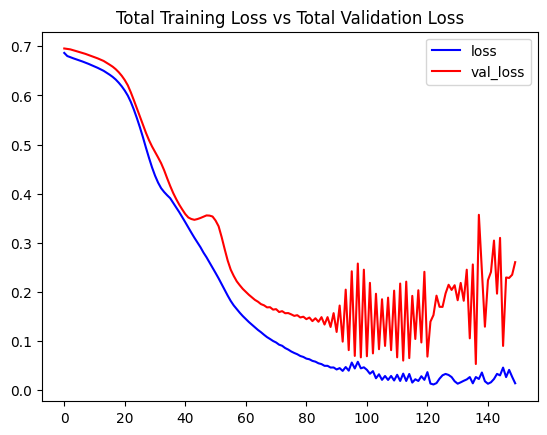

In [38]:
plot_metric('loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

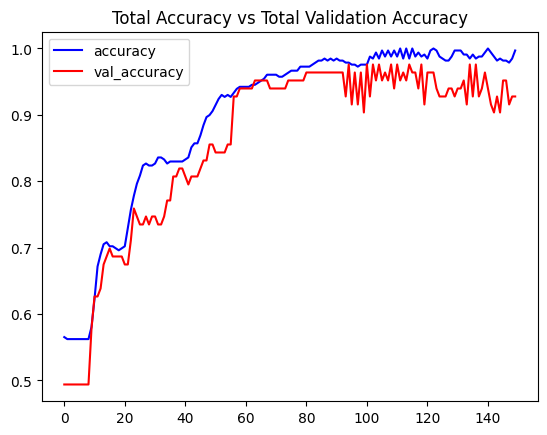

In [39]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')